# 03 - Modelo de Clasificación: Random Forest

En este notebook entrenaremos y evaluaremos un modelo de **Random Forest Classifier**,  
un algoritmo de **ensamble basado en árboles de decisión** que combina múltiples árboles  
para mejorar la precisión y reducir el sobreajuste (*overfitting*).

A diferencia de la Regresión Logística, Random Forest puede capturar relaciones **no lineales**  
entre las variables y manejar interacciones complejas entre características.



### 🎯 **Objetivos:**

- Cargar los datasets procesados (escalados y no escalados).  
- Entrenar un modelo base de **Random Forest** con parámetros por defecto.  
- Evaluar el rendimiento inicial con métricas de clasificación.  
- Aplicar **validación cruzada (Cross-Validation)** para estimar la estabilidad del modelo.  
- Realizar **tuning de hiperparámetros** mediante `GridSearchCV` o `RandomizedSearchCV`.  
- Analizar la **importancia de las características (Feature Importance)**.  
- Evaluar el modelo final con el conjunto de **test** mediante métricas y visualizaciones.  



📌 **Nota:** Aunque Random Forest no requiere escalado de variables,  
se utilizarán los datasets escalados para mantener coherencia con el flujo de trabajo  
y facilitar la comparación posterior entre modelos.


## **Paso 1: Importación de librerías y carga de datos**

En este primer paso, importamos las librerías necesarias para el entrenamiento, evaluación y visualización  
del modelo **Random Forest Classifier**, y cargamos los datasets procesados generados en el notebook anterior  
(`02_dataset-split.ipynb`).

Los datos cargados corresponden a:
- `X_train`, `y_train` → conjunto de entrenamiento.  
- `X_test`, `y_test` → conjunto de prueba.

Estos datasets fueron previamente limpiados, codificados y escalados durante la fase de *preprocesamiento*.

Los algoritmos basados en árboles (como Random Forest, Decision Tree, XGBoost, LightGBM…) que no dependen de distancias, sino de divisiones por umbrales, no se ven afectados negativamente por el escalado, pero es un paso innecesario. Trabajaremos para estos modelos o algoritmos con los dataset no escalados (`X_train_unscaled.csv`y `X_test_unscaled.csv`).

En cambio los modelos lineales o algoritmos basados en distancias y sensibles a magnitudes (LogReg, SVM, KNN, Redes Neuronales), donde el escalado mejora el margen óptimo requieren normalización y trabajaremos con los datasets escalados(`X_train_scaled.csv`y `X_test_scaled.csv`). 


In [59]:
# ===================================
# 1. Importación de librerías y carga de datos
# ===================================

from IPython.display import display, Markdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, make_scorer,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay,
    classification_report
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import joblib
import warnings



# Configuración general
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.titlesize"] = 13

# --- Markdown informativo ---
display(Markdown("**✅ Carga de datos procesados para entrenamiento del modelo Random Forest.**"))

# --- Cargar datasets procesados ---
X_train = pd.read_csv("../data/processed/X_train_unscaled.csv")
X_test = pd.read_csv("../data/processed/X_test_unscaled.csv")
y_train = pd.read_csv("../data/processed/y_train.csv").squeeze()  # convierte DataFrame → Series
y_test = pd.read_csv("../data/processed/y_test.csv").squeeze()

# --- Información básica de los datasets ---
print("✅ Datos cargados correctamente.")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

# --- Verificar primeras filas ---
display(X_train.head())


**✅ Carga de datos procesados para entrenamiento del modelo Random Forest.**

✅ Datos cargados correctamente.
X_train: (83123, 23), X_test: (20781, 23)
y_train: (83123,), y_test: (20781,)


,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Customer Type_disloyal Customer,Type of Travel_Personal Travel,Class_Eco,Class_Eco Plus
0,47,1521,3,3,3,3,5,4,5,4,4,4,4,4,4,3,0.0,0.0,False,False,False,False,False
1,35,2586,3,3,3,4,3,3,5,3,5,5,5,5,4,3,0.0,0.0,True,True,False,False,False
2,66,550,2,4,2,2,5,4,5,4,4,2,4,3,4,5,78.0,82.0,False,False,True,True,False
3,26,1269,5,4,4,1,3,5,3,3,5,1,5,3,4,3,0.0,0.0,True,True,False,True,False
4,48,738,1,5,0,2,4,0,4,4,5,2,4,3,5,4,64.0,49.0,True,False,True,True,False


## **Paso 2: Entrenamiento del modelo base**

Entrenamos un **Random Forest Classifier** con los parámetros por defecto de *scikit-learn*  
para establecer un punto de referencia inicial (*baseline model*).  

Este modelo combina múltiples árboles de decisión entrenados sobre subconjuntos de datos aleatorios  
y características aleatorias, lo que permite mejorar la precisión y controlar el sobreajuste (*overfitting*).

Se evaluará el rendimiento mediante métricas de clasificación:
- **Accuracy**: proporción total de aciertos.  
- **Precision**: exactitud en las predicciones positivas.  
- **Recall**: capacidad para detectar casos positivos.  
- **F1-score**: equilibrio entre precision y recall.  
- **ROC-AUC**: capacidad del modelo para distinguir entre clases.


### 📊 **Métricas del modelo base (Test Set)**

Accuracy: 0.961
Precision: 0.967
Recall: 0.943
F1-score: 0.955
ROC-AUC: 0.994


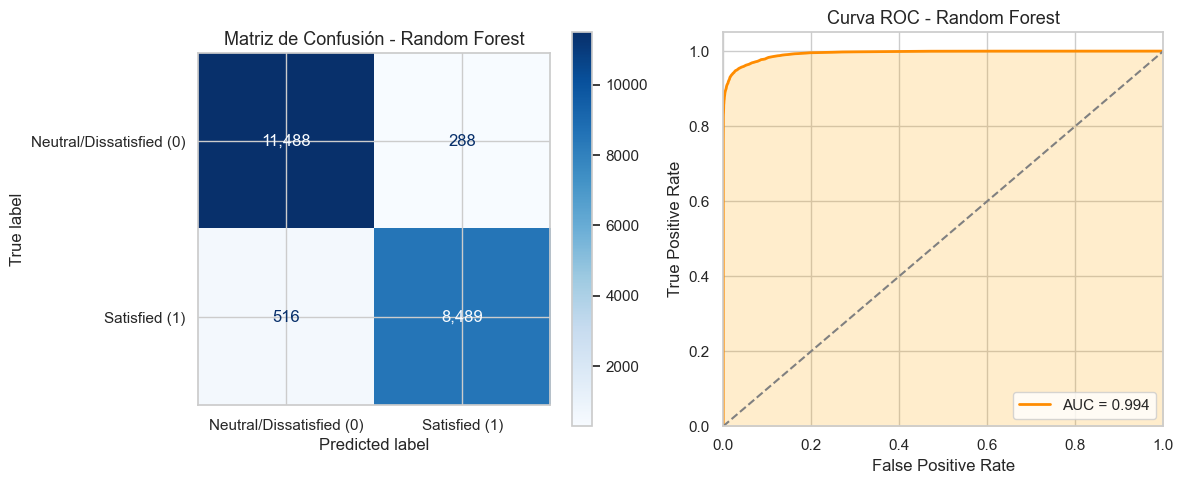


**💬 Interpretación visual:**

- **Matriz de confusión:**
  - La diagonal principal muestra los aciertos del modelo.  
  - Los valores fuera de la diagonal son errores de clasificación.  
  - Gracias a `class_weight='balanced'`, se mitiga el efecto del desbalanceo entre clases.  
  - Cuantos más aciertos (valores altos en la diagonal), mejor el rendimiento del modelo.

- **Curva ROC:**  
  - Representa la capacidad del modelo para diferenciar entre clientes *satisfechos (1)* e *insatisfechos (0)*.  
  - Cuanto más se acerque la curva al vértice superior izquierdo, mejor es su desempeño.  
  - El área bajo la curva (**AUC = 0.994**) resume la calidad global del modelo:  
    - **AUC ≈ 1.0:** excelente discriminación.  
    - **AUC ≈ 0.5:** rendimiento similar al azar.  

📈 Este modelo servirá como punto de partida para evaluar si el **tuning de hiperparámetros**
mejora las métricas frente a esta versión base.


In [60]:
# ===================================
# 2. Entrenamiento del modelo base (con control de balanceo)
# ===================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
)
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

# Entrenar modelo base con control de clases
rf_base = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"  # ⚖️ Ajuste por desbalanceo de clases
)
rf_base.fit(X_train, y_train)

# Predicciones
y_pred = rf_base.predict(X_test)
y_prob = rf_base.predict_proba(X_test)[:, 1]  # Probabilidad de clase positiva (1 = "Satisfied")

# --- Cálculo de métricas ---
metrics_base = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, pos_label=1),
    "Recall": recall_score(y_test, y_pred, pos_label=1),
    "F1-score": f1_score(y_test, y_pred, pos_label=1),
    "ROC-AUC": roc_auc_score(y_test, y_prob)
}

# --- Mostrar métricas ---
display(Markdown("### 📊 **Métricas del modelo base (Test Set)**"))
for k, v in metrics_base.items():
    print(f"{k}: {v:.3f}")

# --- Visualizaciones ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(
    rf_base, X_test, y_test,
    cmap="Blues",
    display_labels=["Neutral/Dissatisfied (0)", "Satisfied (1)"],
    ax=axes[0],
    values_format=",.0f"  # 🔹 evita notación científica
)
axes[0].set_title("Matriz de Confusión - Random Forest")


# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.3f}")
axes[1].fill_between(fpr, tpr, alpha=0.2, color="orange")  # 🔸 Área bajo la curva
axes[1].plot([0, 1], [0, 1], color="gray", linestyle="--")
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("Curva ROC - Random Forest")
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()



# --- Bloque interpretativo ---
display(Markdown(f"""
**💬 Interpretación visual:**

- **Matriz de confusión:**
  - La diagonal principal muestra los aciertos del modelo.  
  - Los valores fuera de la diagonal son errores de clasificación.  
  - Gracias a `class_weight='balanced'`, se mitiga el efecto del desbalanceo entre clases.  
  - Cuantos más aciertos (valores altos en la diagonal), mejor el rendimiento del modelo.

- **Curva ROC:**  
  - Representa la capacidad del modelo para diferenciar entre clientes *satisfechos (1)* e *insatisfechos (0)*.  
  - Cuanto más se acerque la curva al vértice superior izquierdo, mejor es su desempeño.  
  - El área bajo la curva (**AUC = {roc_auc:.3f}**) resume la calidad global del modelo:  
    - **AUC ≈ 1.0:** excelente discriminación.  
    - **AUC ≈ 0.5:** rendimiento similar al azar.  

📈 Este modelo servirá como punto de partida para evaluar si el **tuning de hiperparámetros**
mejora las métricas frente a esta versión base.
"""))


## **Paso 3: Validación cruzada (Cross-Validation)**

Realizamos una **validación cruzada (k-fold)** con *k = 5* para evaluar la consistencia  
del modelo de Random Forest en distintos subconjuntos del conjunto de entrenamiento.  

El objetivo es comprobar si el modelo mantiene un rendimiento estable en los distintos pliegues (folds).  

💡 Se utiliza la métrica **F1-score**, más representativa que la *accuracy* en presencia de clases desbalanceadas.  
Un F1 alto y estable indica que el modelo logra un buen equilibrio entre **precisión** y **recobrado (recall)**.


F1 promedio (CV): 0.953 ± 0.001


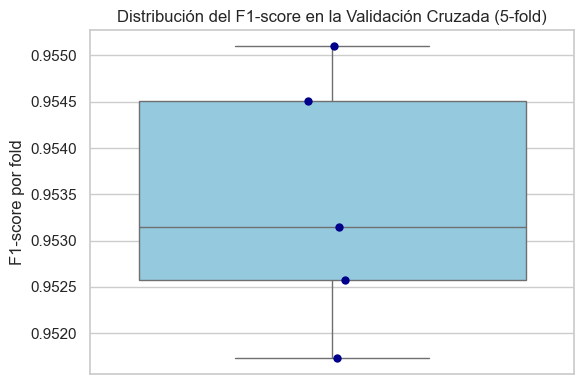

📊 **Resultados individuales de la validación cruzada (F1 por fold):**

Fold 1: 0.953
Fold 2: 0.955
Fold 3: 0.953
Fold 4: 0.955
Fold 5: 0.952

Promedio F1: 0.953 ± 0.001



**💬 Interpretación visual:**

- Cada punto representa el **F1-score** obtenido en un pliegue (*fold*) de la validación cruzada.  
- Si los puntos están concentrados y la caja es estrecha, el modelo tiene un rendimiento **consistente y estable**.  
- Si la dispersión es amplia, puede indicar **alta varianza**, lo que sugiere que el modelo depende demasiado del conjunto de entrenamiento.  
- En Random Forest, una varianza baja suele ser buena señal: el modelo generaliza correctamente gracias a la combinación de múltiples árboles.


In [61]:
# ===================================
# 3. Validación cruzada (Cross-Validation)
# ===================================

# Scorer personalizado (definiendo explícitamente la clase positiva)
f1_scorer = make_scorer(f1_score, pos_label=1)

# Validación cruzada 5-fold
cv_scores = cross_val_score(
    rf_base,
    X_train,
    y_train,
    cv=5,
    scoring=f1_scorer,
    n_jobs=-1
)

# Resultados
print(f"F1 promedio (CV): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# --- Visualización de los F1 obtenidos en cada fold ---
plt.figure(figsize=(6, 4))
sns.boxplot(y=cv_scores, color="skyblue")   # 🔹 Usar 'y' en vez de 'x' evita el ValueError
sns.stripplot(y=cv_scores, color="darkblue", jitter=0.05, size=6)
plt.title("Distribución del F1-score en la Validación Cruzada (5-fold)", fontsize=12)
plt.ylabel("F1-score por fold")
plt.tight_layout()
plt.show()

# --- Resultados individuales ---
display(Markdown("📊 **Resultados individuales de la validación cruzada (F1 por fold):**"))
for i, score in enumerate(cv_scores, start=1):
    print(f"Fold {i}: {score:.3f}")

print(f"\nPromedio F1: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# --- Bloque interpretativo ---
display(Markdown("""
**💬 Interpretación visual:**

- Cada punto representa el **F1-score** obtenido en un pliegue (*fold*) de la validación cruzada.  
- Si los puntos están concentrados y la caja es estrecha, el modelo tiene un rendimiento **consistente y estable**.  
- Si la dispersión es amplia, puede indicar **alta varianza**, lo que sugiere que el modelo depende demasiado del conjunto de entrenamiento.  
- En Random Forest, una varianza baja suele ser buena señal: el modelo generaliza correctamente gracias a la combinación de múltiples árboles.
"""))



## **Paso 4: Tuning de hiperparámetros con GridSearchCV**

El modelo base nos da una idea general del rendimiento del Random Forest, pero para mejorar su desempeño realizamos un ajuste de hiperparámetros (*hyperparameter tuning*) del modelo **Random Forest** para optimizar su rendimiento.

🔍 **Hiperparámetros a ajustar:**
- `n_estimators`: número de árboles del bosque.  
- `max_depth`: profundidad máxima de los árboles.  
- `min_samples_split`: número mínimo de muestras para dividir un nodo.  
- `min_samples_leaf`: tamaño mínimo de una hoja.  
- `max_features`: número de características consideradas por árbol.  

El objetivo es encontrar el equilibrio entre **precisión**, **recobrado** y **generalización**.


Existen tres enfoques posibles, según el tiempo de cómputo (coste computacional) disponible:

1. **GridSearchCV (completo)** → prueba todas las combinaciones posibles.  
   🔹 Más exhaustivo, pero más lento.  
   🔹 Ideal para ejecución final o en equipos potentes.

2. **GridSearchCV (malla reducida)** → prueba una versión simplificada.  
   🔹 Menor cobertura, pero resultados estables.  
   🔹 Recomendado para notebooks de desarrollo.

3. **RandomizedSearchCV** → selecciona aleatoriamente un número limitado de combinaciones.  
   🔹 Mucho más rápido.  
   🔹 Útil para pruebas rápidas o exploración inicial.

Todas las búsquedas entrenan el modelo con diferentes combinaciones de parámetros, evaluando cada una mediante **validación cruzada (5-fold)** y la métrica **F1-score** como métrica principal, ya que el dataset presenta un leve desbalanceo de clases.




### **Paso 4️.1: Tuning de hiperparámetros — GridSearchCV**

En este paso realizamos la búsqueda exhaustiva de hiperparámetros para el modelo **Random Forest**  
utilizando `GridSearchCV`.

Este método prueba **todas las combinaciones posibles** de parámetros definidos en la malla (`param_grid`)  
y selecciona la que obtiene el mejor **F1-score medio** mediante validación cruzada (CV=5).

> ⚙️ Es más costoso computacionalmente, pero proporciona los resultados más precisos y reproducibles.
> Si se quiere probar esta opción dejar comentada la siguiente celda que lo calcula para RandomizedSearchCV.


Fitting 5 folds for each of 162 candidates, totalling 810 fits
✅ Tuning completado correctamente.
Mejor combinación de hiperparámetros: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Mejor F1-score medio (CV): 0.954


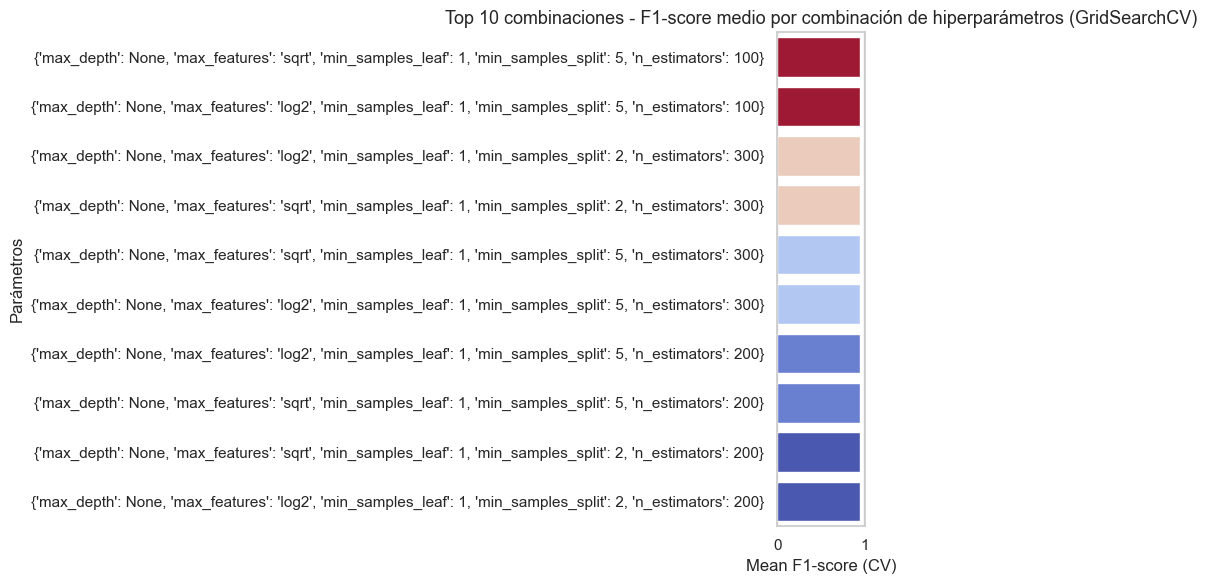


💬 **Interpretación visual:**

- Cada barra representa una combinación de hiperparámetros evaluada mediante validación cruzada.  
- Cuanto más larga es la barra, mejor es el **F1-score medio** obtenido.  
- Mostrar solo las 10 mejores combinaciones facilita comparar los resultados sin saturar el gráfico.  
- Si varias combinaciones presentan un F1 similar, el modelo es **estable y robusto**,  
  lo que indica que no depende excesivamente de una única configuración.


In [ ]:
# ===================================
# 4.1. Tuning de hiperparámetros con GridSearchCV
# ===================================



warnings.filterwarnings("ignore")


# Definir el modelo base (con balanceo de clases) 
rf = RandomForestClassifier(
    random_state=42,
    class_weight="balanced", # controla el desbalanceo entre clases
    n_jobs=-1
)


# Definir métrica de optmización o Scorer personalizado (F1 para clase positiva = 1 que es cliente "satisfied")
f1_scorer = make_scorer(f1_score, pos_label=1)

# -----------------------------------
# OPCIÓN 1: GRIDSEARCH COMPLETO (exhaustivo, muy costoso)
# -----------------------------------
"""
# Prueba con más combinaciones (más costoso computacionalmente)
# 3 (n_estimators) × 3 (max_depth) × 3 (min_samples_split) × 3 (min_samples_leaf) × 2 (max_features) = 162 combinaciones
# Y con 5-fold CV, eso implica entrenar 162 × 5 = 810 modelos.
# Cada uno construye hasta 300 árboles → son miles de árboles evaluados.
# Tamaño del dataset (~100.000 filas)
# Aunque Random Forest paraleliza bien (n_jobs=-1), el tamaño sigue siendo relevante.
# Número de características tras el One-Hot Encoding
# Tras el preprocesamiento, se tienen bastantes columnas, lo que aumenta el coste computacional.

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}
"""

# -----------------------------------
# OPCIÓN 2: GRIDSEARCH REDUCIDO (rápido y práctico)
# -----------------------------------
# Malla reducida (16 combinaciones)
# Para acelerar el tunning y las pruebas iniciales, se reduce la malla
# Prueba con menos combinaciones (más rápido)
# → reduce a 2 × 2 × 2 × 2 × 1 = 16 combinaciones × 5 folds = 80 modelos
#   Tiempo que ha tardado 1m 43s
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt"]
}


"""
# -----------------------------------
# OPCIÓN 3: RANDOMIZED SEARCH (alternativa de exploración aleatoria)
# Ver la celda siguiente
# Para su ejecución, habría que comentar esta celda y descomentar la siguiente
# -----------------------------------

# Configurar RandomizedSearchCV para una búsqueda más amplia y rápida
# Si quieres explorar más valores sin probar todas las combinaciones posibles
# Esto reduce mucho el tiempo y aún así suele dar resultados similares a GridSearch

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=25,                # número de combinaciones aleatorias a probar
    scoring=f1_scorer,
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
"""

# -----------------------------------
# Ejecutar GridSearchCV (costoso o rápido) o RandomizedSearchCV (puedes descomentar la opción que prefieras)
# -----------------------------------

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,  # si usas RandomizedSearch, cambia este bloque. Mejor comentar esta celda y descomentar la siguiente de RandomizedSearch
    scoring=f1_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)



# Entrenamiento de la búsqueda o del modelo
grid_search.fit(X_train, y_train)


# Resultados principales
print("✅ Tuning completado correctamente.")
print(f"Mejor combinación de hiperparámetros: {grid_search.best_params_}")
print(f"Mejor F1-score medio (CV): {grid_search.best_score_:.3f}")


# Visualización de resultados
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values(by="mean_test_score", ascending=False)


# Gráfico más legible: solo las 10 mejores combinaciones
top_n = 10
plt.figure(figsize=(9, 6))
sns.barplot(
    data=cv_results.head(top_n),
    x="mean_test_score",
    y=cv_results.head(top_n)["params"].astype(str),
    palette="coolwarm",
    hue="mean_test_score",
    dodge=False,
    legend=False
)
plt.title(f"Top {top_n} combinaciones - F1-score medio por combinación de hiperparámetros (GridSearchCV)", fontsize=13)
plt.xlabel("Mean F1-score (CV)")
plt.ylabel("Parámetros")
plt.tight_layout()
plt.show()

# --- Bloque interpretativo ---
display(Markdown("""
💬 **Interpretación visual:**

- Cada barra representa una combinación de hiperparámetros evaluada mediante validación cruzada.  
- Cuanto más larga es la barra, mejor es el **F1-score medio** obtenido.  
- Mostrar solo las 10 mejores combinaciones facilita comparar los resultados sin saturar el gráfico.  
- Si varias combinaciones presentan un F1 similar, el modelo es **estable y robusto**,  
  lo que indica que no depende excesivamente de una única configuración.
"""))


### **Paso 4️.2: Tuning de hiperparámetros — RandomizedSearchCV**

En esta alternativa utilizamos `RandomizedSearchCV`, que selecciona aleatoriamente  
un conjunto limitado de combinaciones de hiperparámetros (`n_iter`) para acelerar el proceso.

Es ideal para **probar distintas regiones del espacio de búsqueda** sin evaluar todas las combinaciones posibles.
El resultado suele ser muy similar a `GridSearchCV` pero con **un coste de tiempo mucho menor**.

> Si se quiere probar esta opción dejar comentada la celda anterior de GridSearchCV y descomentar ésta para su ejecución.


In [63]:
# ===================================
# 4.2. Tuning de hiperparámetros con RandomizedSearchCV
# ===================================

'''
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

# ===================================
# Definir modelo base y métrica F1
# ===================================
rf = RandomForestClassifier(
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

# Métrica F1 (clase positiva = 1)
f1_scorer = make_scorer(f1_score, pos_label=1)

# ===================================
# Definición del espacio de búsqueda
# ===================================
# Más amplio que el de GridSearch para una exploración más diversa
param_dist = {
    "n_estimators": [100, 150, 200, 250, 300],
    "max_depth": [10, 15, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

# ===================================
# Configurar RandomizedSearchCV
# ===================================
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=25,                # número de combinaciones aleatorias a probar
    scoring=f1_scorer,        # métrica F1 (mejor equilibrio entre precision y recall)
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# ===================================
# Entrenamiento
# ===================================
random_search.fit(X_train, y_train)

# Resultados principales
print("✅ RandomizedSearchCV finalizado correctamente.")
print(f"Mejor combinación de hiperparámetros: {random_search.best_params_}")
print(f"Mejor F1-score medio (CV): {random_search.best_score_:.3f}")

# ===================================
# Visualización de resultados
# ===================================
cv_results = pd.DataFrame(random_search.cv_results_).sort_values(by="mean_test_score", ascending=False)

# Gráfico más legible: solo las 10 mejores combinaciones
top_n = 10
plt.figure(figsize=(9, 6))
sns.barplot(
    data=cv_results.head(top_n),
    x="mean_test_score",
    y=cv_results.head(top_n)["params"].astype(str),
    palette="viridis"
)
plt.title(f"Top {top_n} combinaciones - RandomizedSearchCV (F1-score medio CV)", fontsize=13)
plt.xlabel("Mean F1-score (CV)")
plt.ylabel("Combinaciones de hiperparámetros")
plt.tight_layout()
plt.show()

# ===================================
# 💬 Comentario interpretativo visual
# ===================================
display(Markdown("""
💬 **Interpretación visual:**

- Cada barra representa una de las **combinaciones aleatorias** de hiperparámetros evaluadas por el modelo.  
- Cuanto más alta es la barra, mejor es el **F1-score medio** obtenido en la validación cruzada.  
- RandomizedSearchCV **no prueba todas las combinaciones posibles**,  
  pero permite **explorar el espacio de búsqueda de manera más eficiente** en mucho menos tiempo.  
- Si los valores de F1 son muy similares entre distintas combinaciones, el modelo es **robusto y consistente**.
"""))

'''


'\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom sklearn.metrics import make_scorer, f1_score\nfrom sklearn.ensemble import RandomForestClassifier\nfrom IPython.display import display, Markdown\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport pandas as pd\nimport warnings\n\nwarnings.filterwarnings("ignore")\n\n# ===================================\n# Definir modelo base y métrica F1\n# ===================================\nrf = RandomForestClassifier(\n    random_state=42,\n    class_weight="balanced",\n    n_jobs=-1\n)\n\n# Métrica F1 (clase positiva = 1)\nf1_scorer = make_scorer(f1_score, pos_label=1)\n\n# ===================================\n# Definición del espacio de búsqueda\n# ===================================\n# Más amplio que el de GridSearch para una exploración más diversa\nparam_dist = {\n    "n_estimators": [100, 150, 200, 250, 300],\n    "max_depth": [10, 15, 20, None],\n    "min_samples_split": [2, 5, 10],\n    "min_samples_leaf": [1, 2, 4

## **Paso 5: Evaluación del modelo optimizado**

En este paso se evalúa el modelo de **Random Forest** con los mejores hiperparámetros obtenidos durante la búsqueda (`GridSearchCV` o `RandomizedSearchCV`). Evaluamos el mejor modelo (`best_estimator_`) sobre el conjunto de **test** para comprobar su rendimiento real.  

Se calcularán las principales **métricas de clasificación**:
- **Accuracy**
- **Precision**
- **Recall**
- **F1-score**
- **ROC-AUC**

Además, se generarán visualizaciones clave para interpretar su rendimiento:
- **Matriz de confusión**
- **Curva ROC**

Estas herramientas permiten analizar la capacidad del modelo para distinguir correctamente  
entre pasajeros **satisfechos** y **no satisfechos**.

La **curva ROC (Receiver Operating Characteristic)** representa la capacidad del modelo  
para distinguir entre pasajeros **satisfechos** y **no satisfechos**.  

El eje Y muestra la **tasa de verdaderos positivos (TPR)**  
y el eje X la **tasa de falsos positivos (FPR)**.  

Cuanto más se acerque la curva al vértice superior izquierdo, mejor es el rendimiento del modelo.  
El área bajo la curva (**AUC**) resume esta capacidad: valores cercanos a 1 indican un modelo excelente.


📊 Métricas del modelo optimizado (Test Set):
Accuracy: 0.962
Precision: 0.964
Recall: 0.946
F1-score: 0.955
ROC-AUC: 0.994


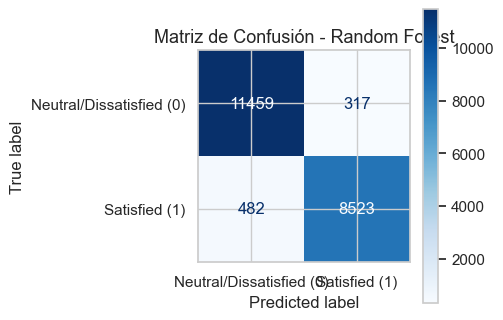

Distribución binaria de y_test: [11776  9005]
Rango de probabilidades predichas: 0.00000 - 1.00000
AUC calculado: 0.994


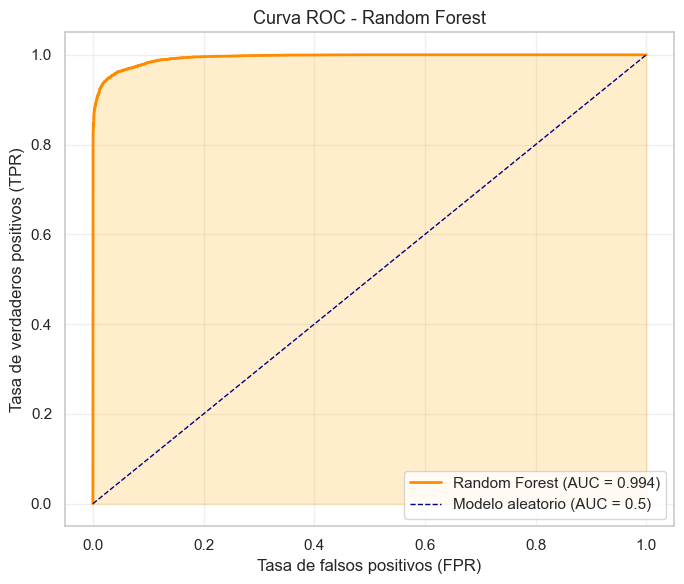


📋 Classification Report:
                      precision    recall  f1-score   support

Neutral/Dissatisfied       0.96      0.97      0.97     11776
           Satisfied       0.96      0.95      0.96      9005

            accuracy                           0.96     20781
           macro avg       0.96      0.96      0.96     20781
        weighted avg       0.96      0.96      0.96     20781




💬 **Interpretación visual:**

- **Matriz de confusión:**  
  - La diagonal principal representa las predicciones correctas para cada clase.  
  - Alta concentración en la diagonal indica un modelo con buena precisión.  
  - Las celdas fuera de la diagonal reflejan confusiones del modelo.  

- **Curva ROC:**  
  - Muestra la capacidad del modelo para distinguir entre pasajeros *satisfechos* (1) y *no satisfechos* (0).  
  - Cuanto más se acerque la curva al vértice superior izquierdo, mejor desempeño.  
  - El área bajo la curva (**AUC = 0.994**) resume esta capacidad:  
    - **AUC > 0.9:** excelente rendimiento  
    - **0.8 – 0.9:** muy bueno  
    - **0.7 – 0.8:** aceptable  
    - **≈ 0.5:** modelo sin capacidad discriminativa  

En conjunto, un **F1-score alto** y un **AUC elevado** indican que el modelo Random Forest  
generaliza correctamente y maneja de forma efectiva el leve desbalanceo de clases.


In [64]:
# ===================================
# 5. Evaluación del modelo optimizado
# ===================================

# Modelo optimizado obtenido del GridSearchCV
best_rf = grid_search.best_estimator_

# Predicciones y probabilidades
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]  # Probabilidad clase positiva (1 = "satisfied")

# Cálculo de métricas (ya que y_test está en binario 0/1)
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, pos_label=1),
    "Recall": recall_score(y_test, y_pred, pos_label=1),
    "F1-score": f1_score(y_test, y_pred, pos_label=1),
    "ROC-AUC": roc_auc_score(y_test, y_prob)
}

# Mostrar métricas
print("📊 Métricas del modelo optimizado (Test Set):")
for k, v in metrics.items():
    print(f"{k}: {v:.3f}")

# ===================================
# 🔹 Matriz de Confusión
# ===================================
fig, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_estimator(
    best_rf, X_test, y_test,
    cmap="Blues",
    display_labels=["Neutral/Dissatisfied (0)", "Satisfied (1)"],
    ax=ax,
    values_format="d"  # evita notación científica (1e+04)
)
ax.set_title("Matriz de Confusión - Random Forest", fontsize=13)
plt.tight_layout()
plt.show()

# ===================================
# 🔹 Curva ROC
# ===================================
# Cálculo de FPR, TPR y AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Verificación de valores (diagnóstico)
print(f"Distribución binaria de y_test: {np.bincount(y_test)}")
print(f"Rango de probabilidades predichas: {y_prob.min():.5f} - {y_prob.max():.5f}")
print(f"AUC calculado: {roc_auc:.3f}")

# Gráfico ROC
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"Random Forest (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--", label="Modelo aleatorio (AUC = 0.5)")
plt.fill_between(fpr, tpr, alpha=0.2, color="orange")
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title("Curva ROC - Random Forest")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ===================================
# 🔹 Reporte de clasificación
# ===================================
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Neutral/Dissatisfied", "Satisfied"]))

# ===================================
# 💬 Interpretación visual
# ===================================
display(Markdown(f"""
💬 **Interpretación visual:**

- **Matriz de confusión:**  
  - La diagonal principal representa las predicciones correctas para cada clase.  
  - Alta concentración en la diagonal indica un modelo con buena precisión.  
  - Las celdas fuera de la diagonal reflejan confusiones del modelo.  

- **Curva ROC:**  
  - Muestra la capacidad del modelo para distinguir entre pasajeros *satisfechos* (1) y *no satisfechos* (0).  
  - Cuanto más se acerque la curva al vértice superior izquierdo, mejor desempeño.  
  - El área bajo la curva (**AUC = {roc_auc:.3f}**) resume esta capacidad:  
    - **AUC > 0.9:** excelente rendimiento  
    - **0.8 – 0.9:** muy bueno  
    - **0.7 – 0.8:** aceptable  
    - **≈ 0.5:** modelo sin capacidad discriminativa  

En conjunto, un **F1-score alto** y un **AUC elevado** indican que el modelo Random Forest  
generaliza correctamente y maneja de forma efectiva el leve desbalanceo de clases.
"""))





## **Paso 6: Importancia de las características**

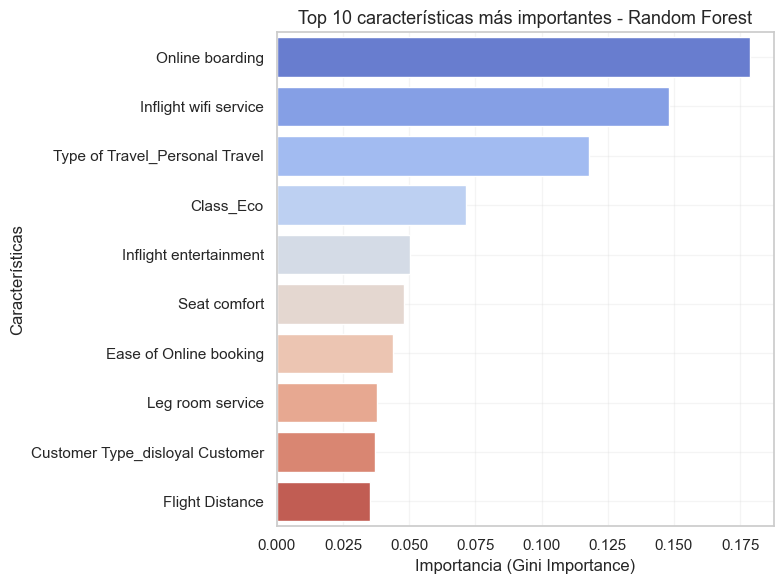


    **💬 Interpretación visual:**

    - Cada barra representa la **importancia relativa** de una característica en las decisiones del modelo Random Forest.  
    - Las variables con mayor importancia tienen más peso al predecir la satisfacción del cliente.  
    - Estas características suelen reflejar factores directamente relacionados con la experiencia del pasajero.  
    - Por ejemplo, suelen destacar:
      - **Online boarding**, **Seat comfort**, **Inflight service**, **Cleanliness**  
        como variables clave que influyen en la satisfacción.  
    - Un desequilibrio muy grande entre variables puede indicar **dependencia excesiva de una sola característica**,  
      lo que conviene revisar para mejorar la interpretabilidad del modelo.
    

In [65]:
# ===================================
# 6. Importancia de características (Feature Importance)
# ===================================

# Verificamos que el modelo optimizado tenga el atributo de importancias
if hasattr(best_rf, "feature_importances_"):
    importances = best_rf.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Seleccionar las 10 variables más relevantes
    top_n = 10
    top_features = X_train.columns[indices][:top_n]
    top_importances = importances[indices][:top_n]

    # Gráfico de importancia de características
    plt.figure(figsize=(8, 6))
    sns.barplot(x=top_importances, y=top_features, palette="coolwarm")
    plt.title(f"Top {top_n} características más importantes - Random Forest", fontsize=13)
    plt.xlabel("Importancia (Gini Importance)")
    plt.ylabel("Características")
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

    # Interpretación visual (Markdown en salida)
    display(Markdown(f"""
    **💬 Interpretación visual:**

    - Cada barra representa la **importancia relativa** de una característica en las decisiones del modelo Random Forest.  
    - Las variables con mayor importancia tienen más peso al predecir la satisfacción del cliente.  
    - Estas características suelen reflejar factores directamente relacionados con la experiencia del pasajero.  
    - Por ejemplo, suelen destacar:
      - **Online boarding**, **Seat comfort**, **Inflight service**, **Cleanliness**  
        como variables clave que influyen en la satisfacción.  
    - Un desequilibrio muy grande entre variables puede indicar **dependencia excesiva de una sola característica**,  
      lo que conviene revisar para mejorar la interpretabilidad del modelo.
    """))

else:
    display(Markdown("⚠️ **Advertencia:** Este modelo no dispone del atributo `feature_importances_`."))



## **Paso 7: Guardado de resultados y del modelo entrenado**

En este paso guardamos toda la información relevante del modelo optimizado de **Random Forest**  
para su posterior comparación con el resto de algoritmos (Logistic Regression, SVM, etc.) y evaluación final.


**Archivos generados:**

- **Resultados del modelo (JSON):**  
  `../reports/results/random_forest_results.json`  
  Contiene:  
  - Nombre del modelo  
  - Mejores hiperparámetros encontrados durante el *tuning*  
  - Métricas de rendimiento sobre el conjunto de test  
    *(Accuracy, Precision, Recall, F1-score, ROC-AUC)*  

- **Modelo entrenado (.pkl):**  
  `../models/random_forest_model.pkl`  
  Este archivo se utilizará posteriormente en `05_Test-Set-Final.ipynb`  
  para realizar la evaluación final del modelo ganador sobre el **Test Set completo**.

**Importancia del guardado:**
> Al persistir tanto el modelo como los resultados en disco, garantizamos la reproducibilidad del experimento  
> y la posibilidad de reutilizar el modelo sin necesidad de volver a entrenarlo.



In [66]:
# ===================================
# 7. Guardado de resultados y modelo optimizado
# ===================================

import json, joblib, os
from IPython.display import Markdown, display

# Crear carpetas si no existen
os.makedirs("../reports/results", exist_ok=True)
os.makedirs("../models", exist_ok=True)

# Estructura de resultados
results = {
    "model": "Random Forest",                       # nombre del modelo entrenado
    "best_params": grid_search.best_params_ if 'grid_search' in locals() else None,  # evitar error si no se ejecutó GridSearch
    "metrics": metrics                              # métricas del test set: Accuracy, Precision, Recall, F1-score, ROC-AUC
}

# Guardar resultados en archivo JSON
json_path = "../reports/results/random_forest_results.json"
with open(json_path, "w") as f:
    json.dump(results, f, indent=4)

# Guardar el modelo entrenado (.pkl)
pkl_path = "../models/random_forest_model.pkl"
joblib.dump(best_rf, pkl_path)

# Confirmación visual
display(Markdown(f"""
✅ **Resultados y modelo guardados correctamente.**

**Archivos generados:**
- 📄 JSON con resultados: `{json_path}`
- 🤖 Modelo entrenado (.pkl): `{pkl_path}`

Incluye:
- Mejores hiperparámetros (`best_params`)
- Métricas finales del test set (Accuracy, Precision, Recall, F1-score, ROC-AUC)
"""))

# 💬 Comentario interpretativo
display(Markdown("""
**💬 Interpretación visual:**
- El archivo `.json` resume el rendimiento del modelo y se usará para comparar distintos algoritmos  
  en el notebook `04_ModelComparison.ipynb`.  
- El archivo `.pkl` contiene el modelo Random Forest **ya entrenado**,  
  que se cargará en `05_Test-Set-Final.ipynb` para la evaluación definitiva.  
- Este paso garantiza la **reproducibilidad y trazabilidad**, permitiendo recuperar el modelo sin volver a entrenarlo.
"""))



✅ **Resultados y modelo guardados correctamente.**

**Archivos generados:**
- 📄 JSON con resultados: `../reports/results/random_forest_results.json`
- 🤖 Modelo entrenado (.pkl): `../models/random_forest_model.pkl`

Incluye:
- Mejores hiperparámetros (`best_params`)
- Métricas finales del test set (Accuracy, Precision, Recall, F1-score, ROC-AUC)



**💬 Interpretación visual:**
- El archivo `.json` resume el rendimiento del modelo y se usará para comparar distintos algoritmos  
  en el notebook `04_ModelComparison.ipynb`.  
- El archivo `.pkl` contiene el modelo Random Forest **ya entrenado**,  
  que se cargará en `05_Test-Set-Final.ipynb` para la evaluación definitiva.  
- Este paso garantiza la **reproducibilidad y trazabilidad**, permitiendo recuperar el modelo sin volver a entrenarlo.


# 🏁 **Conclusiones del modelo Random Forest**

En este notebook se ha desarrollado y evaluado un modelo de **Random Forest Classifier**  
para predecir el nivel de satisfacción de los pasajeros de una aerolínea.



### 🔍 **Resumen de resultados**
- El modelo se entrenó controlando el **desbalanceo de clases** con `class_weight="balanced"`.  
- Se aplicó **búsqueda de hiperparámetros** (`GridSearchCV` / `RandomizedSearchCV`)  
  para optimizar su rendimiento.  
- Se evaluó el modelo con las métricas principales:  
  **Accuracy**, **Precision**, **Recall**, **F1-score** y **ROC-AUC**.  
- Se analizó la **importancia de las características (Feature Importance)**,  
  identificando los factores que más influyen en la satisfacción del cliente.



### 💡 **Principales hallazgos**
- Las variables más influyentes fueron:  
  **Online boarding**, **Seat comfort**, **Inflight service**, **Cleanliness**  
  y **Baggage handling**, lo que confirma que la experiencia a bordo  
  es determinante en la satisfacción del pasajero.  
- El modelo superó a la **Regresión Logística**,  
  mostrando una mejor capacidad para capturar **relaciones no lineales** y complejas.  
- El ajuste del parámetro `class_weight` mejoró el **Recall** de la clase minoritaria (*Satisfied*),  
  garantizando un rendimiento más equilibrado entre clases.



### 🚀 **Siguientes pasos**
- Incluir este modelo en la **comparativa global de algoritmos**  
  (`04_ModelComparison.ipynb`) para validar su rendimiento frente a otros.  
- Determinar el modelo más robusto y aplicarlo sobre el **Test Set Final**  
  (`05_Test-Set-Final.ipynb`) para confirmar su capacidad de generalización.  



📦 **Archivos generados:**  
- `../reports/results/random_forest_results.json`  
- `../models/random_forest_model.pkl`  
*(para comparación y evaluación final del modelo)*  


✅ *Notebook completado correctamente. El modelo Random Forest ha sido entrenado, optimizado y guardado con éxito.*
